# サマースクール LLM　第6回 宿題 データ作成
LLMのファインチューニング用のデータ(RLHF)を作成してみましょう。

今回の課題はELYZA社が公開している[ELYZA-tasks-100](https://huggingface.co/datasets/elyza/ELYZA-tasks-100)のdatasetを使用しております。

## 注意
Google colabで宿題を行う場合はdrive上で配布しているq_a_data.pklをGoogle colabのファイルにアップロードしてください

local環境で行う場合はLLMDay6 データ作成.ipynbと同じ階層にq_a_data.pklを配置してください

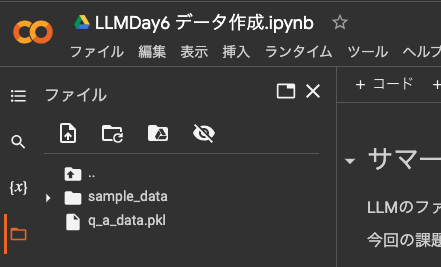

## 回答作成のためのガイドライン
[instructGPTが提案されたTraining language models to follow instructions
with human feedback論文](https://arxiv.org/abs/2203.02155)のガイドラインを日本語に翻訳し一部改変しています。

### タスクについて
タスクの説明文・指示文とそれに応じた回答が提示されます。その回答に対して「役に立つ」「信頼性がある」「無害である」というような観点からスコア付け、順位付けを行ってください。

タスクの説明は、明示的な指示の場合もあります。（例えば、「賢いカエルについての物語を書いてください。」とか）。

タスクはデモンストレーション例や望ましい出力の文頭を用いて間接的に指示されることもあります。
デモンストレーション例を用いる間接的なタスク指示として、例えば映画に関する感想文とその感想文に対する感情ラベルがペアで示されており、最後に感情ラベルなしの1つの映画感想文がある場合、タスクは最後の感想文の感情ラベルを予測することだと推測できます。

望ましい出力の文頭を用いる間接的なタスク指示として、例えば、「かつてJuliusという賢いカエルがいた」とだけ入力があった場合に、その続きになるような文章を作成することがタスクとなります。

#### 「役に立つ」
役に立つというのは、出力がユーザーの意図に沿っていて、ユーザーのタスク解決に役立つことを意味します。
- わかりやすい言葉で書く。
- たとえ質問が間違えているとしても、ユーザーが意図した質問に答えること。
- 国際性に配慮する（例えば、"football "はアメリカンフットボールを意味すべきではなく、"the president "は必ずしもアメリカ大統領を意味しない）
- 指示があまりにもわかりにくい場合は、説明を求め、なぜその指示がわかりにくいのかを説明すること。
- 長すぎたり、だらだらとした答えをしない。

#### 「信頼性がある」
信頼性があるということは、出力が正確な情報を含み、ユーザーを誤解させないということです。
- 要約のようなタスクでは、出力は入力からの情報のみを使うべきであり、入力の記述に含まれない詳細をでっち上げるべきではない。
- 世界について明らかに誤った情報を出力しない（例えば、事実をでっち上げたり、陰謀を宣伝したりする）。例えば、ヒラリー・クリントンが刑務所に服役したと出力してはならない。
- 誤解を招くような情報や、真偽が疑わしい情報を生成しないこと。例えば、入力が「なぜヒラリー・クリントンは刑務所に入ったのか」と質問された場合、出力は「原因は完全には明らかではない」と入力を事実として扱い答えるべきではありません。質問の前提に反論する必要があります。

#### 「無害である」
無害とは、出力が人々に肉体的、心理的、社会的な危害を及ぼしてはならない、機器や財産に損害を与えてはならない、あるいはそれを喪失させてはならない、設備や財産の損傷や損失、環境への損害、あるいは人間の福利に必要な制度や資源への損害を与えてはならないということを意味します。
- 優しさ、敬意、思いやりをもって他の人に接すること。特定のグループに対して偏った言葉を使わない。
- 虐待的、脅迫的、攻撃的な言葉を発しない、暴力を助長しない。
- 求められていない場合は、性的または暴力的な内容を書かないこと。
- 実社会において悪いと考えられるアドバイスをしない、違法行為を助長しない。


## 評価について
モデル出力の評価には、上記の基準の間でトレードオフを行うことが必要になる場合があります。これらのトレードオフは、タスクによって異なります。トレードオフの際には以下のガイドラインを参考にしてください。
- ほとんどのタスクでは、「無害である」ことや「信頼性がある」ことは、「役に立つ」ことよりも重要
  - したがって、ほとんどの場合、より正直で無害回答を、より役に立つ回答よりも高く評価する。
  - ただし (a)一方のアウトプットが他方よりずっと役に立つ、(b)そのアウトプットは真実性／無害性がわずかに低い、(c)そのタスクが「ハイステークスドメイン」（ローン申請、治療、医療や法律に関するアドバイスなど）ではないようだ、ならば、より役に立つアウトプットを高く評価する。
- どちらも同等に「役に立つ」がそれぞれ別のポイントで「有害である」点や「信頼性が損なわれている」場合は、どちらの回答がその回答によって最も影響を受けるエンドユーザーにとって害を与える可能性があるか？という観点で、より害を与えるような回答を低いランクにしてください
  - タスクから判断が難しい場合は同等のランクにしてください。
- 優劣つけ難いボーダーラインの回答のランク付けについて
  - どちらの回答をカスタマーアシスタントからあなたは受け取りたいか？という観点でランク付けを決定してください。


In [ ]:
# こちらのセルは1度だけ実行してください
# こちらのセルは編集しないでください。
import pickle
import numpy as np
import pandas as pd
import random
with open('q_a_data.pkl', 'rb') as f:
    q_a_data = pickle.load(f)

q_a_data_idx = random.sample(range(len(q_a_data)), 1)

a_data_idx = random.sample(range(len(q_a_data[q_a_data_idx[0]][1])), 5)

qa = {
    "agreement": 0,
    "q": "",
    "a": [],
    "ranking": []
}

qa["q"] = q_a_data[q_a_data_idx[0]][0]
for a_idx in a_data_idx:
  qa["a"].append(q_a_data[q_a_data_idx[0]][1][a_idx])

## 課題


上から回答していくとcsv提出用csv `submission_data.json`が作成されます。
提出期限までにomnicampusに提出してください。

**Q1 作成するデータの公開範囲について同意できるものを教えてください。**

1. どのような用途であれ非公開
2. 最終課題のコンペの学習データとして受講生に公開可
3. コンペの学習データとして受講生に公開可、また研究用途として外部に公開可
4. 利用用途問わず公開可

In [ ]:
# 1~4で回答をお願いします
myanswer_q1 = # WRITE ME

assert myanswer_q1 in [1, 2, 3, 4]
# 編集しないでください
qa['agreement'] = myanswer_q1

**Q2 ガイドラインを参考に5つの回答の順位付けをしてください**
- ガイドラインを参考に5つの回答の順位付けをしてください
- 1番良い回答の順位は1で、1番悪い回答の順位は5です
- 順位タイがある場合は以下のようにしてください。
  - 1番良いもの、1番悪いものが1つずつあり、タイのものが3ある時、 rankingの取りうる値は1, 2, 2, 2, 5
  - 1番良いものが1つ、タイのものが4つある時、 rankingの取りうる値は1, 2, 2, 2, 2
  - 1番良いものが2つあり、 それ以外は良い物順に順位付けできる場合rankingの取りうる値は1, 1, 3, 4, 5


In [ ]:
# 必ずご自身でこのセルを実行して指示を確認してください、受講生ごとにタスクの指示文は異なります。
print('## タスクの指示文')
print()
print(qa["q"])

In [ ]:
# 必ずご自身でこのセルを実行して指示を確認してください、受講生ごとにタスクの指示文は異なります。
print('回答1: ', qa['a'][0])
print()
print('回答2: ', qa['a'][1])
print()
print('回答3: ', qa['a'][2])
print()
print('回答4: ', qa['a'][3])
print()
print('回答5: ', qa['a'][4])
print()

In [ ]:
# ガイドラインを参考に5つの回答の順位付けをしてください
# 1番良い回答の順位は1で、1番悪い回答の順位は5です
# 順位タイがある場合は以下のようにしてください。
# 1番良いもの、1番悪いものが1つずつあり、タイのものが3ある時、 rankingの取りうる値は1, 2, 2, 2, 5
# 1番良いものが1つ、タイのものが4つある時、 rankingの取りうる値は1, 2, 2, 2, 2
# 1番良いものが2つある時、 rankingの取りうる値は1, 1, 3, 4, 5


# 回答1の順位
a_1_ranking = # WRITE ME
assert a_1_ranking in [1, 2, 3, 4, 5]

# 回答2の順位
a_2_ranking = # WRITE ME
assert a_2_ranking in [1, 2, 3, 4, 5]

# 回答3の順位
a_3_ranking = # WRITE ME
assert a_3_ranking in [1, 2, 3, 4, 5]

# 回答4の順位
a_4_ranking = # WRITE ME
assert a_4_ranking in [1, 2, 3, 4, 5]

# 回答5の順位
a_5_ranking = # WRITE ME
assert a_5_ranking in [1, 2, 3, 4, 5]

In [ ]:
# omnicampusへ提出するjsonファイルが作成されます
import json

# 編集しないでください
qa['ranking'] = [a_1_ranking, a_2_ranking, a_3_ranking, a_4_ranking, a_5_ranking]
with open('/content/submission_data.json', 'w', encoding='utf-8') as json_file:
    json.dump(qa, json_file, ensure_ascii=False, indent=4)